# **Prototype - Finding Straight Lane Lines on the Road** 
***
Welcome to the Gentle CV Intro for Self-Driving Car. We are going to use the tools we discussed earlier to identify **straight** lane lines on the road. That is the goal of this notebook. We will prototype a simple UI in order to help us identify what the best method to find straight lane lines on the road.

We will develop series of pipeline using openCV and we might be able to apply the later result to video stream.

Check out [CS231n Python for basics](http://cs231n.github.io/python-numpy-tutorial/). It gives really good amount of tutorial for doing things with **numpy**. 

---
Without further due, let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

Here's what we are trying to build 

<figure>
 <img src="assets/FinalBuild.jpeg" width="500" alt="Final Prototype" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your prototype should look something like above</p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="assets/UI_example.jpeg" width="500" alt="UI Prototype" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> If there is no image gets selected, our starter code will show like above</p> 
 </figcaption>
</figure>

### Let's import some libraries here

We will use numpy, sys, itertools, common Python library, openCV and matplotlib. If you have any issue getting this library you might consider to create new Python environment through **conda**


In [1]:
import numpy as np
import sys
import itertools
import os
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Load image here

There are several **test_images** you can find to start prototyping.

This image is: <class 'numpy.ndarray'> with dimesions: (530, 895, 3)


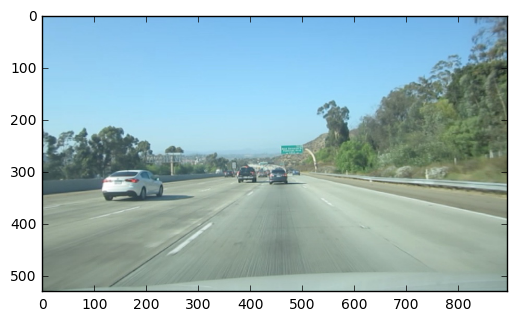

In [3]:
#reading in an image
img = mpimg.imread('test_1.jpg')
#printing out some stats and plotting
print('This image is:', type(img), 'with dimesions:', img.shape)
plt.imshow(img)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

Let's Do Color Selection and Region Masking

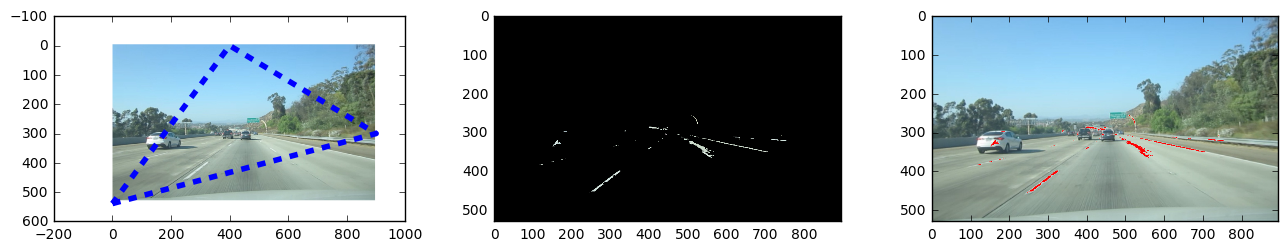

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image and print out some stats
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
image = img

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
# MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
# MODIFY THESE VALUES TO ISOLATE THE REGION 
# WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [0, 539]
right_bottom = [900, 300]
apex = [400, 0]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]


# Display the image and show region and color selections
plt.figure(figsize=[16, 9])
plt.subplot(3,3,1)
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)

plt.subplot(3,3,2)
plt.imshow(color_select)
plt.subplot(3,3,3)
plt.imshow(line_image)


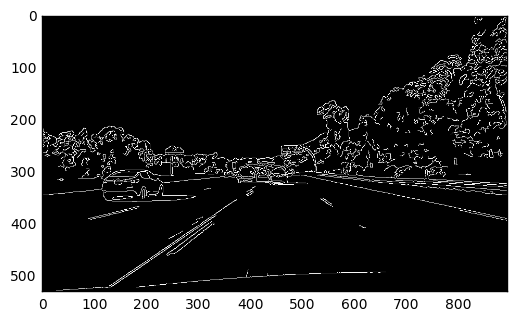

In [17]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 100
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')

## Continue on Images - Apply Hough Transform



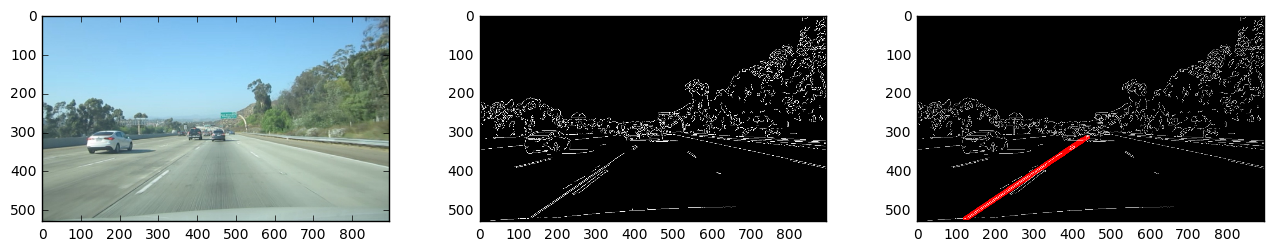

In [66]:
def make_mask(image,
        mask_horizontal_aperture = 30,
        mask_vertical_adjustment = 50):
    """Generate vertices to be used as a mask.
    
    Bottom vertices are at the bottom corners of the image, the other two
    vertices are at the center of the image adjusted by the two parameters.
    """
    height, width = image.shape[:2]
    vertices = np.array([[
        (0, height - 1),
        ((width - 1) // 2 - mask_horizontal_aperture,
            (height - 1) // 2 + mask_vertical_adjustment),
        ((width - 1) // 2 + mask_horizontal_aperture,
            (height - 1) // 2 + mask_vertical_adjustment),
        (width - 1, height - 1)]],
        dtype=np.int32)
    return vertices


# Read in and grayscale the image
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 100
high_threshold = 50
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = make_mask(image)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 40     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 300 #minimum number of pixels making up a line
max_line_gap = 150    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on


# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

        
# Create a "color" binary image to combine with line image
plt.figure(figsize=[16, 9])
plt.subplot(3,3,1)
plt.imshow(image)

color_edges = np.dstack((edges, edges, edges)) 
plt.subplot(3,3,2)
plt.imshow(color_edges)

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.subplot(3,3,3)
plt.imshow(lines_edges)



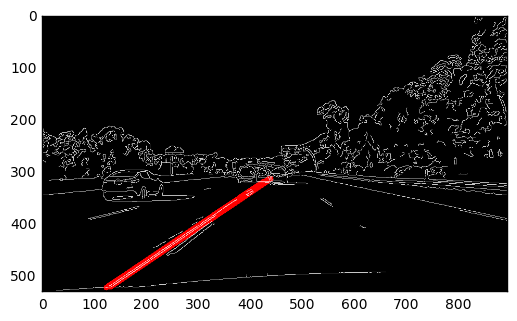

In [67]:
plt.imshow(lines_edges)